In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# sns.set_context("talk")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fn = "/content/drive/MyDrive/krafthack/data/input_dataset-2.parquet"

In [4]:
y_cols = [f"Bolt_{i}_Tensile" for i in range(1, 7)]
x_cols = ['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
          'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
          'Turbine_Rotational Speed', 'mode']

In [5]:
class DataPrep:
  def __init__(self, fn):
    self.df = pd.read_parquet(fn)

    self._df = None

  def run(self, df):
    # mode -> numeric
    mode_le = LabelEncoder()
    df['mode_num'] = mode_le.fit_transform(df['mode'].values)
    
    # add feature: elapsed time since start
    self.elapsed(df)

    # columns with nans (seems to be the same for all bolts)
    df.dropna(inplace=True)
    
    # (for convenience only)
    self._df = df

    x_names = x_cols + ["elapsed", "mode_num"]
    x_names.remove("mode")
    x = df[x_names]
    y = df[y_cols]
    return x, y

  def elapsed(self, df):
    """elapsed time since last start"""
    s = (df["mode"]=="start").cumsum()
    df["_t"] = df.index

    shifted = df["mode"].shift(1).fillna("operation")
    df["_startup"] = (df["mode"] == "start") & (shifted == "operation")
    # df["_change"] = ~(df["mode"] == df["mode"].shift(1))
    #df["_change"] = df["_change"] & df["mode"]=="start"
    # df["_change"] = True & True

    # mimics start at t=0 --> wrong -> impute value instead
    df["_startup"].iloc[0]=True
    df["elapsed"] = (df['_t']-df['_t'].where(df["_startup"]).ffill()).dt.total_seconds()

    # impute values for first interval (as it starts at "operational" state)
    i_first_start = df.index.get_loc(df.index[df["mode"] == "start"][0])
    df.iloc[:i_first_start]["elapsed"] += df["elapsed"].mean()

  def train_test_split(self, **kwargs):
    kwargs.setdefault("shuffle", False)
    return train_test_split(self.df, **kwargs)


prep = DataPrep(fn)
df_train, df_test = prep.train_test_split(test_size=0.3)

x_train, y_train = prep.run(df_train)
x_test, y_test = prep.run(df_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
# get all values to explore trends
prep.run(df_train.append(df_test))
df = prep._df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Diving into the data

Correlation Matrix

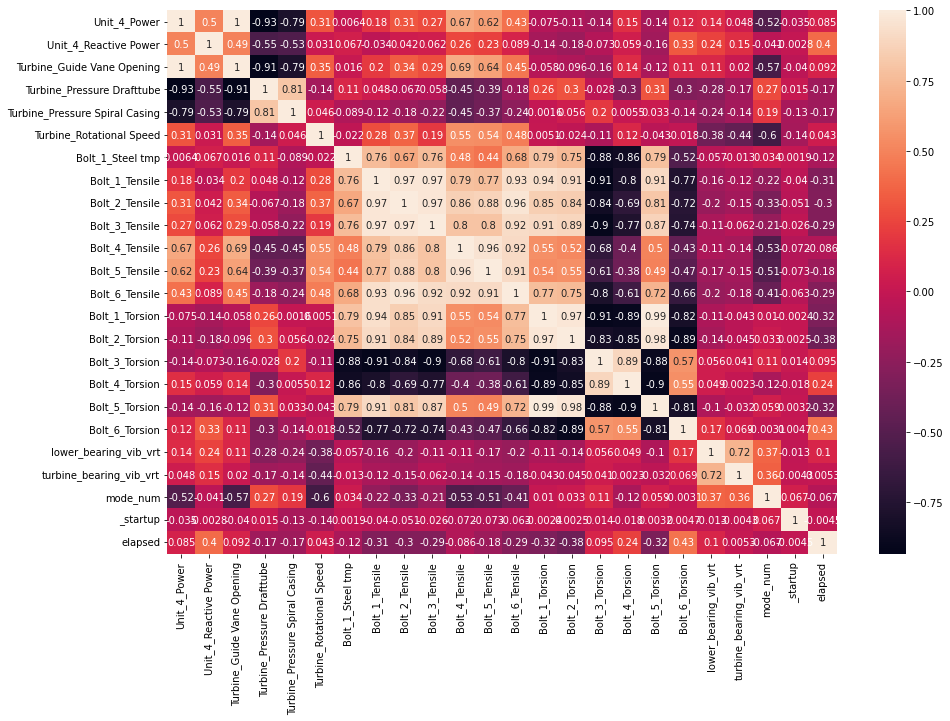

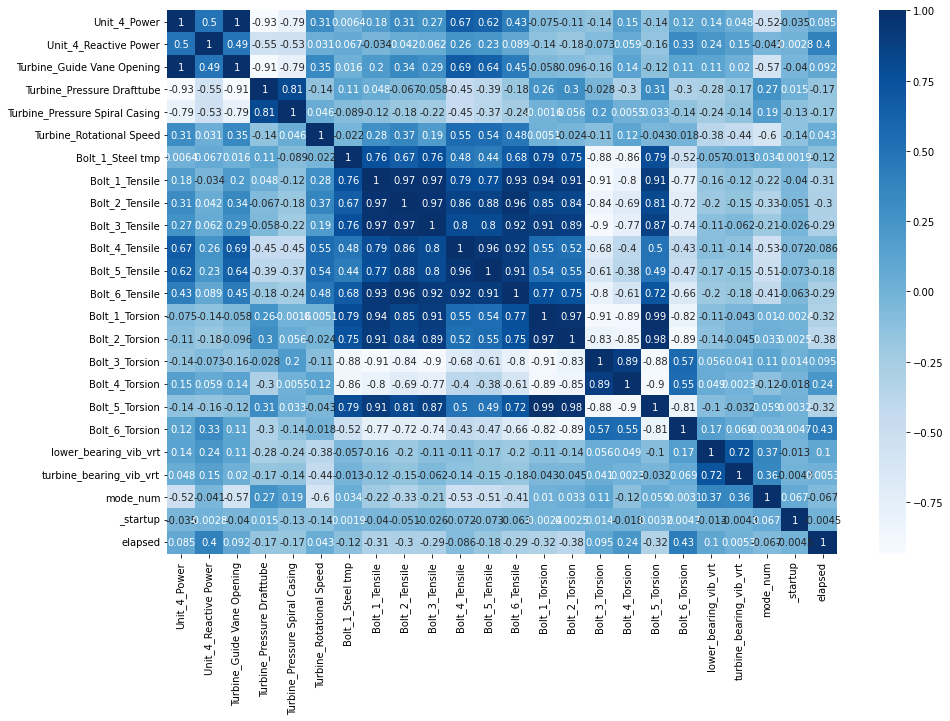

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, ax=ax)

# note the two groups: Tsensile values of Bolt 1-3, and Bolt 4 & 5  -- Bolt 6 is "inbetween"
# - Bolt 1-3: Low correlation with features
# - Bolt 4 & 5: High correlation with features

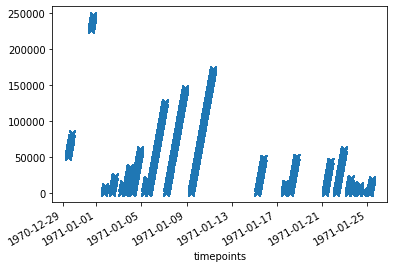

In [8]:
# show the "elapsed" time since start
df["elapsed"].plot(lw=0, marker="x")

# --> first period is just a "guesstimate"

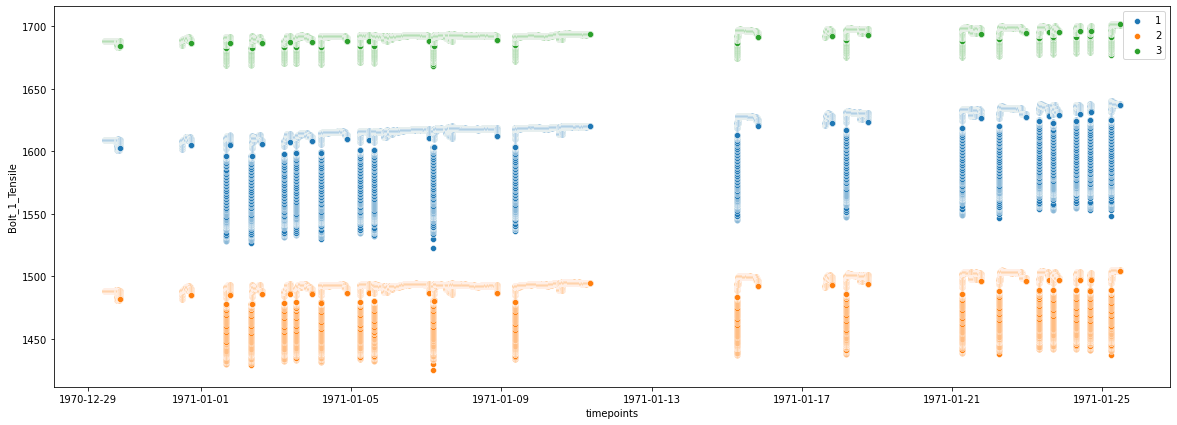

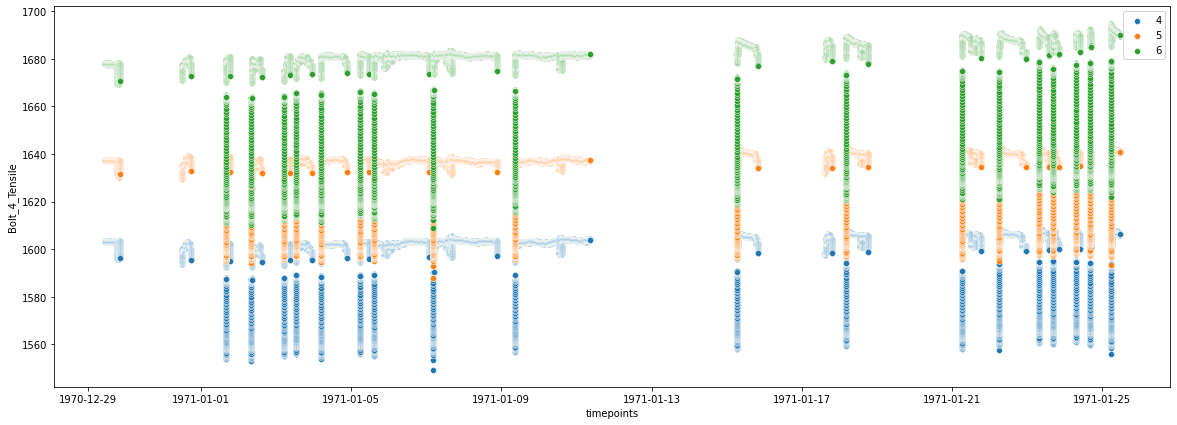

In [9]:
# evolution of tensile values over clock-time --> observe the startup phase
# we see a linear increase for bolt 1-3 (6)
fig, ax = plt.subplots(figsize=(20,7))
for i in range(1, 4):
  sns.scatterplot(data=df, x="timepoints", y=f"Bolt_{i}_Tensile", ax=ax, label=i)

fig, ax = plt.subplots(figsize=(20,7))
for i in range(4, 7):
  sns.scatterplot(data=df, x="timepoints", y=f"Bolt_{i}_Tensile", ax=ax, label=i)

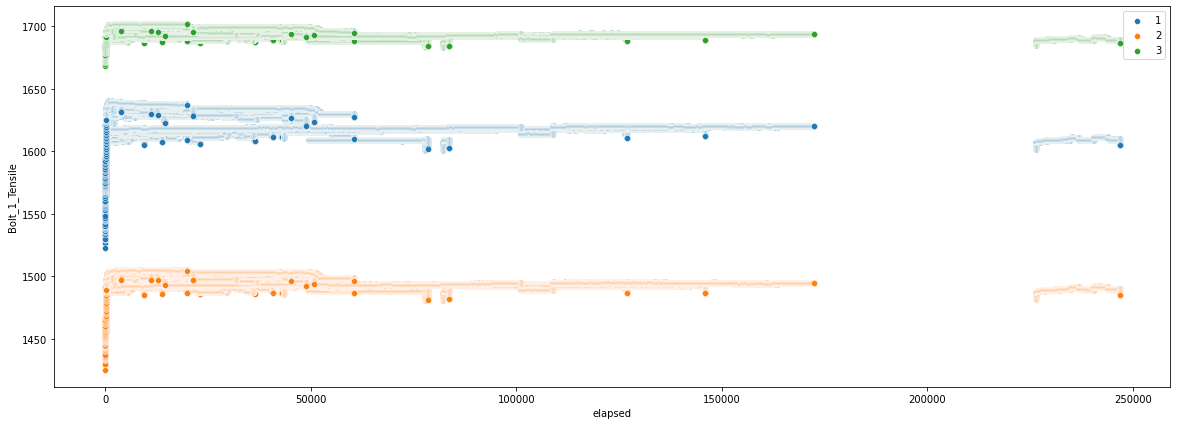

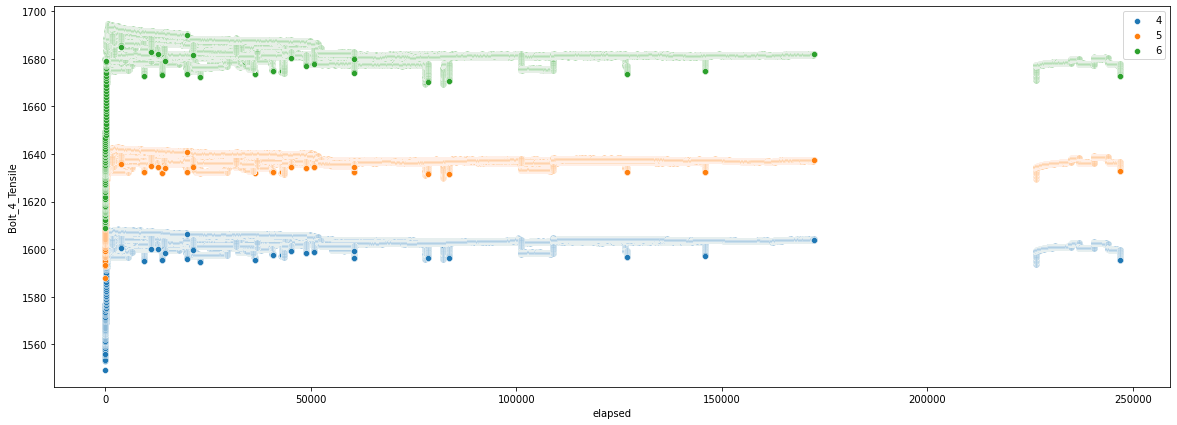

In [10]:
# evolution of tensile values over elapsed time (since mode="start")
fig, ax = plt.subplots(figsize=(20,7))
for i in range(1, 4):
  sns.scatterplot(data=df, x="elapsed", y=f"Bolt_{i}_Tensile", ax=ax, label=i)

fig, ax = plt.subplots(figsize=(20,7))
for i in range(4, 7):
  sns.scatterplot(data=df, x="elapsed", y=f"Bolt_{i}_Tensile", ax=ax, label=i)

In [11]:
# change in tension since they were tightened first time
pretension = [1483, 1437, 1612, 1598, 1629, 1636]

dtension = pretension - df[y_cols].median() # cut/ignore very different values (sensor inaccuracy)
diff = pd.DataFrame()
diff["abs"] = dtension
diff["rel_perc"] = dtension / pretension * 100

diff["abs_at_start"] = pretension- df[y_cols].iloc[0]
diff["res_at_start"] = (pretension- df[y_cols].iloc[0]) / pretension * 100
diff
# larger changes for bolts close to fraction!?

,abs,rel_perc,abs_at_start,res_at_start
Bolt_1_Tensile,-135.376153,-9.128534,-126.140569,-8.505770
Bolt_2_Tensile,-56.582980,-3.937577,-51.522739,-3.585438
Bolt_3_Tensile,-80.846106,-5.015267,-76.519258,-4.746852
Bolt_4_Tensile,-5.185468,-0.324497,-5.236155,-0.327669
Bolt_5_Tensile,-8.346996,-0.512400,-8.373796,-0.514045
Bolt_6_Tensile,-45.472236,-2.779477,-42.107726,-2.573822


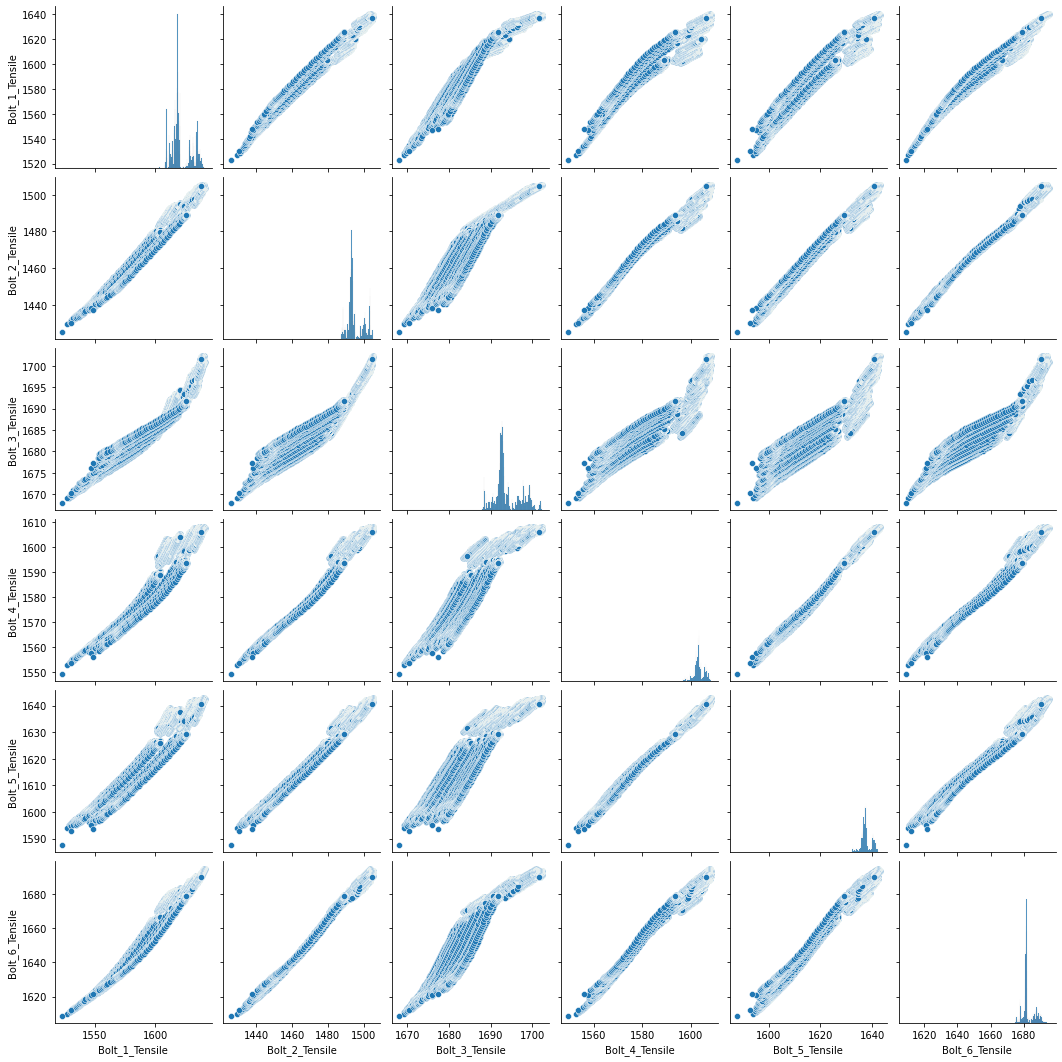

In [13]:
# how about correlations in the tensile values?
sns.pairplot(df[y_cols])

(1, 400)

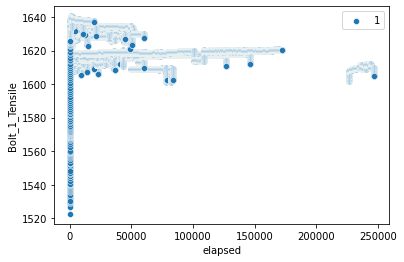

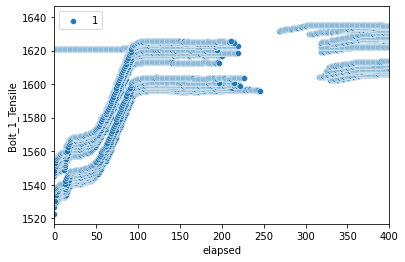

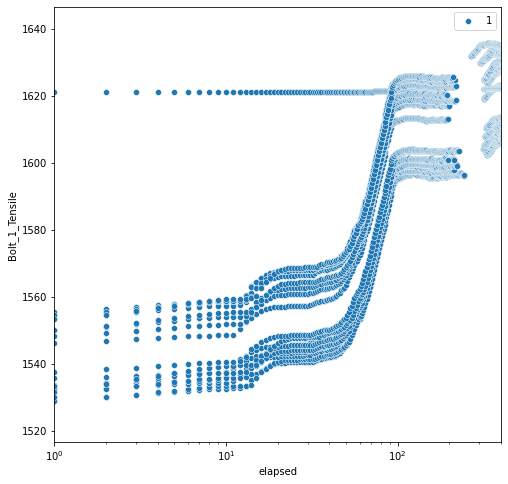

In [14]:
# split start phase, as it has a very differnt behavior?

# see some big differences in the strains -- should be separated eventually
# "logistic growth" vs linear also at startup
fig, ax = plt.subplots()
i=1
sns.scatterplot(data=df, x="elapsed", y=f"Bolt_{i}_Tensile", ax=ax, label=i)

fig, ax = plt.subplots()
i=1
sns.scatterplot(data=df, x="elapsed", y=f"Bolt_{i}_Tensile", ax=ax, label=i)
ax.set_xlim(0, 400)

fig, ax = plt.subplots(figsize=(8, 8))
i=1
sns.scatterplot(data=df, x="elapsed", y=f"Bolt_{i}_Tensile", ax=ax, label=i)
ax.set_xscale('log')
ax.set_xlim(1, 400)

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
# does the initial phase matter for the map (-> no, but intresting to look at :) )
df_clean = df[~df["Bolt_1_Tensile"].isnull()]
map1 = mean_absolute_percentage_error(df_clean["Bolt_1_Tensile"], df_clean["Bolt_1_Tensile"].mean())

df_lg = df_clean[df_clean["elapsed"]<100]
map2 = mean_absolute_percentage_error(df_lg["Bolt_1_Tensile"], df_lg["Bolt_1_Tensile"].mean())

df_lg = df_clean[df_clean["elapsed"]>100]
map3 = mean_absolute_percentage_error(df_lg["Bolt_1_Tensile"], df_lg["Bolt_1_Tensile"].mean())
map1, map2, map3

(0.4223235100963751, 1.3504047840655793, 0.4192141380458772)

## what is the difference between the two "groups" seen at the starup phase?

In [18]:
# # look at the relation to the time it was off (t since last mode == operation)
# restart = df["_startup"]
# df["offtime"] = np.nan
# for i, row  in df[restart].iterrows():
#   d_last = df.iloc[df.index.get_loc(i)-1]
#   t_last = d_last._t
#   df.at[i, "offtime"] = (i-t_last).total_seconds()

In [21]:
# df_cp = df.copy()
# df_cp["offtime"] = df_cp["offtime"].ffill()

# fig, ax = plt.subplots(figsize=(10, 7))
# i = 4
# n = len(df)
# sns.scatterplot(data=df_cp, x="elapsed", y=f"Bolt_{i}_Tensile", hue="offtime", ax=ax, label=i)
# ax.set_xlim(0, 400)
# ax.set_xlabel("t_elapsed [s]")
# ax.set_ylabel("Bolt 4 Tensile [µm/m]")

In [22]:
# # same for Bolt 1
# fig, ax = plt.subplots(figsize=(10, 7))
# i = 1
# n = len(df)
# sns.scatterplot(data=df_cp, x="elapsed", y=f"Bolt_{i}_Tensile", hue="offtime", ax=ax, label=i)
# ax.set_xlim(0, 400)
# ax.set_xlabel("t_elapsed [s]")
# ax.set_ylabel("Bolt 1 Tensile [µm/m]")

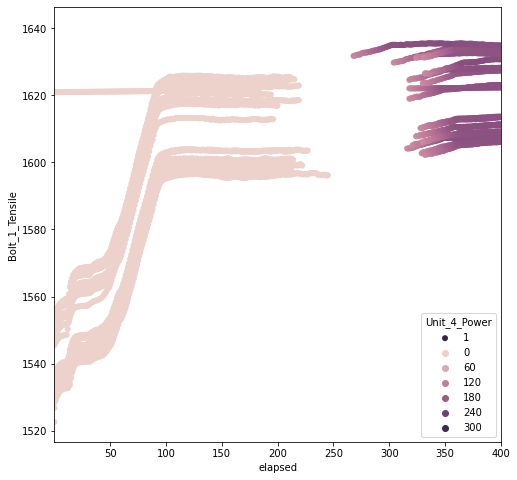

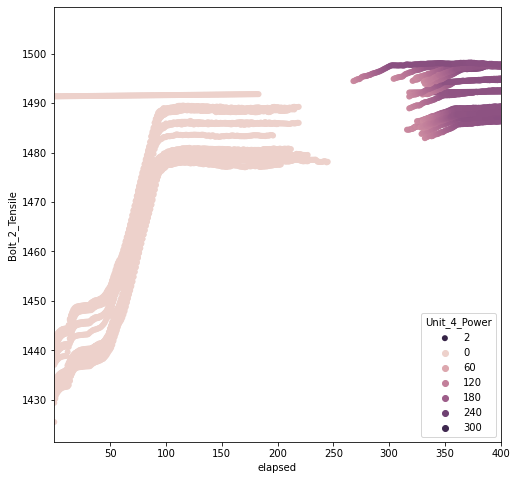

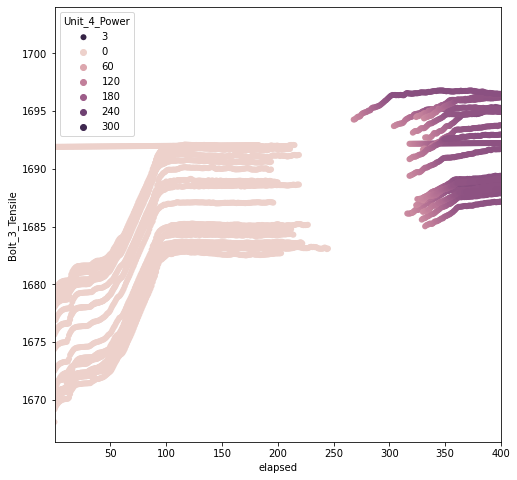

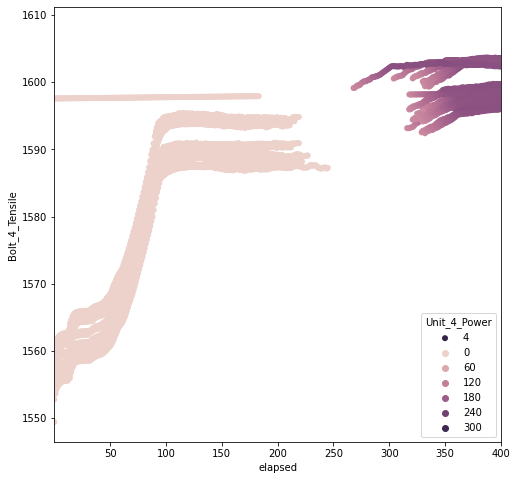

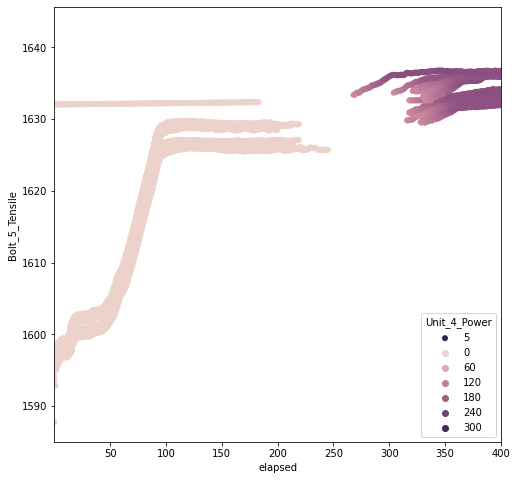

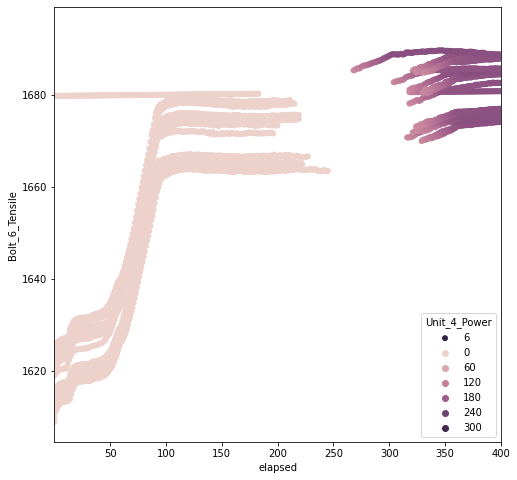

In [24]:
for i in range(1,7):
  fig, ax = plt.subplots(figsize=(8, 8))
  # df_ = df_cp.iloc[20_000:300_000]
  # df_ = df_[df_["Unit_4_Power"]==0]
  sns.scatterplot(data=df, x="elapsed", y=f"Bolt_{i}_Tensile", 
                  hue="Unit_4_Power", ax=ax, label=i,
                  linewidth=0)
  ax.set_xlim(0.1, 400)

# power "1" in legend is eronneous

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


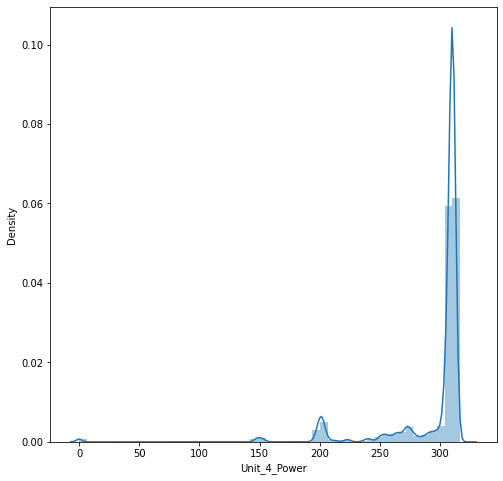

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(df["Unit_4_Power"], ax=ax)
# ax.set_xlim(0.1, 400)

(0.1, 400.0)

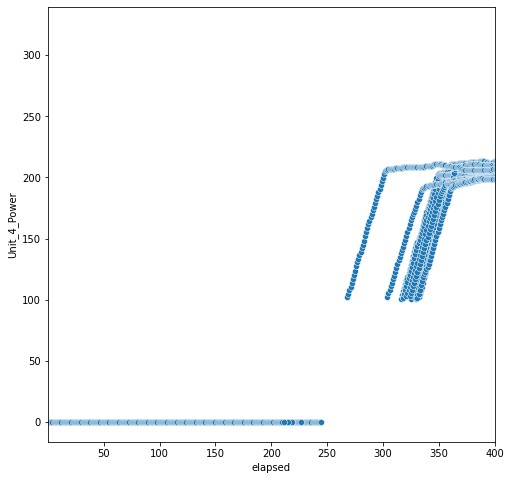

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="elapsed", y=f"Unit_4_Power", ax=ax)
ax.set_xlim(0.1, 400)